In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import libraries needed for reading image and processing it
import csv
from PIL import Image
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

In [31]:
# Training digits images and labels files
letters_training_images_file_path  = "drive/My Drive/Vietnamese/data/training images.zip"
letters_training_labels_file_path  = "drive/My Drive/Vietnamese/data/training labels.zip"
# Testing digits images and labels files
letters_testing_images_file_path  = "drive/My Drive/Vietnamese/data/testing images.zip"
letters_testing_labels_file_path  = "drive/My Drive/Vietnamese/data/testing labels.zip"

# Loading dataset into dataframes
training_letters_images  = pd.read_csv(letters_training_images_file_path, compression='zip', header=None)
training_letters_labels  = pd.read_csv(letters_training_labels_file_path, compression='zip', header=None)
testing_letters_images  = pd.read_csv(letters_testing_images_file_path, compression='zip', header=None)
testing_letters_labels  = pd.read_csv(letters_testing_labels_file_path, compression='zip', header=None)

# print statistics about the dataset
print("There are %d training Vietname letter images of 64x64 pixels." %training_letters_images.shape[0])
print("There are %d testing Vietname letter images of 64x64 pixels." %testing_letters_images.shape[0])
training_letters_images.head()
testing_letters_images.head()

There are 17688 training Vietname letter images of 64x64 pixels.
There are 3960 testing Vietname letter images of 64x64 pixels.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
training_letters_labels.head()

,0
0,10
1,11
2,22
3,22
4,22


Convert csv values to an image
Writting a method to be used later if we want visualization of an image from its pixels values.

In [0]:
def convert_values_to_image(image_values, display=False):
  image_array = np.asarray(image_values)
  image_array = image_array.reshape(64, 64).astype('uint8')
  # The original dataset is reflected so we will flip it then rotate for a better view only.
  #image_array = np.flip(image_array, 0)
  image_array = rotate(image_array, 0)
  new_image = Image.fromarray(image_array)
  if display == True:
    new_image.show()
  return new_image


Visualizing some examples

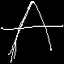

In [0]:
convert_values_to_image(training_letters_images.loc[0], True)

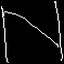

In [0]:
convert_values_to_image(training_letters_images.loc[3], True)

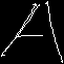

In [0]:
convert_values_to_image(testing_letters_images.loc[0], True)

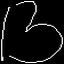

In [33]:
convert_values_to_image(testing_letters_images.loc[1], True)

Data Preprocessing Image Normalization We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [0]:
training_letters_images = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')
testing_letters_images = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')

In [0]:
print("Training images of digits after scaling")
print(training_letters_images.shape)
training_letters_images[0:5]
print("Testing images of digits after scaling")
print(testing_letters_images.shape)
testing_letters_images[0:5]

Training images of digits after scaling
(17688, 4096)
Testing images of digits after scaling
(3960, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Encoding Categorical Labels From the labels csv files we can see that labels are categorical values and it is a multi-class classification problem.

Our outputs are in the form of:

Digits from 0 to 9 have categories numbers from 0 to 9 Letters from ’A’ to ’Ộ’ have categories numbers from 10 to 98 Here we will encode these categories values using One Hot Encoding with keras.

One-hot encoding transforms integer to a binary matrix where the array contains only one ‘1’ and the rest elements are ‘0’.

In [0]:
from keras.utils import to_categorical

# one hot encoding
# number of classes = 10 (digits classes) + 89 (Vietnamese alphabet classes)
number_of_classes = 99
training_letters_labels_encoded = to_categorical(training_letters_labels, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels, num_classes=number_of_classes)
print(training_letters_labels_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Reshaping Input Images to 64x64x1

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape (nb_samples,rows,columns,channels)

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

So we will reshape the input images to a 4D tensor with shape (nb_samples, 64, 64 ,1) as we use grayscale images of 64x64 pixels.

In [0]:
# reshape input letter images to 64x64x1
training_letters_images = training_letters_images.reshape([-1, 64, 64, 1])
testing_letters_images = testing_letters_images.reshape([-1, 64, 64, 1])


print(training_letters_images.shape, training_letters_labels.shape, testing_letters_images.shape, testing_letters_labels.shape)


(17688, 64, 64, 1) (17688, 1) (3960, 64, 64, 1) (3960, 1)


In [0]:
training_data_images = training_letters_images
training_data_labels = training_letters_labels_encoded
print("Total Training images are {} images of shape".format(training_data_images.shape[0]))
print(training_data_images.shape, training_data_labels.shape)


testing_data_images =testing_letters_images
testing_data_labels = testing_letters_labels_encoded
print("Total Testing images are {} images of shape".format(testing_data_images.shape[0]))
print(testing_data_images.shape, testing_data_labels.shape)

Total Training images are 17688 images of shape
(17688, 64, 64, 1) (17688, 99)
Total Testing images are 3960 images of shape
(3960, 64, 64, 1) (3960, 99)


In [0]:
  # create model
  model = Sequential()
  
  optimizer='adam'
  kernel_initializer='uniform'
  activation='relu'
  
  model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(GlobalAveragePooling2D())
  
  #Fully connected final layer
  model.add(Dense(99, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
  

# Model Summary And Visualization
Let's see the model summary.

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)       

In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

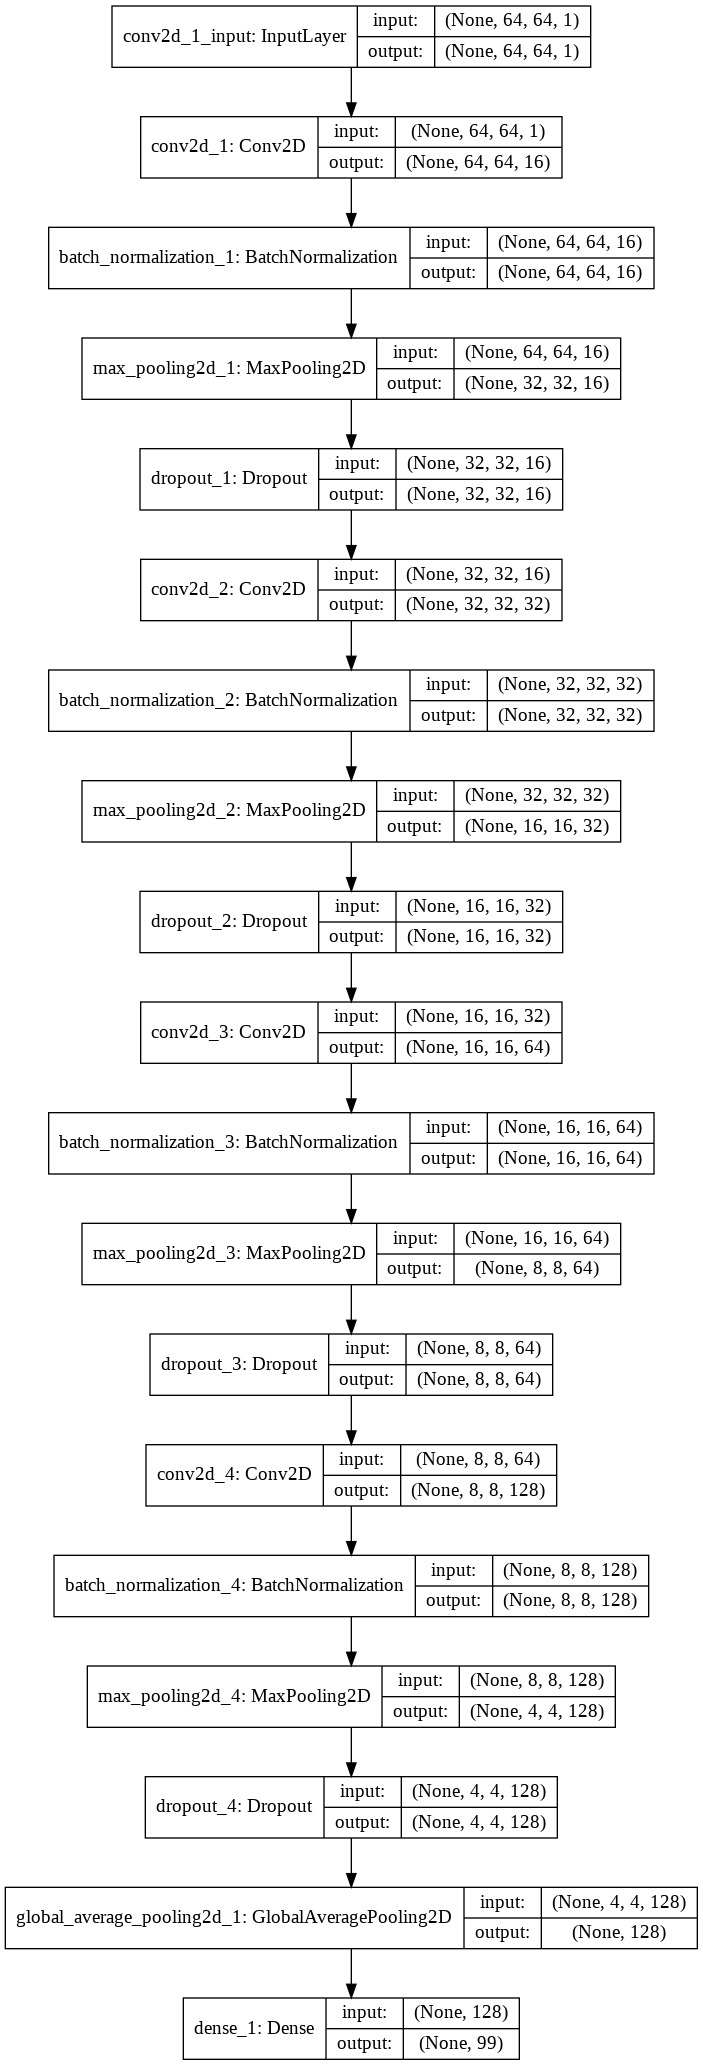

In [0]:
from keras.utils import plot_model

plot_model(model, to_file="drive/My Drive/Vietnamese/model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('drive/My Drive/Vietnamese/model.png'))

In [0]:
epochs = 5
batch_size = 20 # 20 divides the training data samples

history=model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1)
print("=============================================================================")

Train on 17688 samples, validate on 3960 samples
Epoch 1/5
17688/17688 [==============================] - 140s 8ms/step - loss: 2.4418 - acc: 0.4322 - val_loss: 1.4162 - val_acc: 0.6654
Epoch 2/5
17688/17688 [==============================] - 138s 8ms/step - loss: 0.8275 - acc: 0.7968 - val_loss: 0.7644 - val_acc: 0.8253
Epoch 3/5
17688/17688 [==============================] - 138s 8ms/step - loss: 0.4853 - acc: 0.8736 - val_loss: 0.6874 - val_acc: 0.8477
Epoch 4/5
17688/17688 [==============================] - 138s 8ms/step - loss: 0.3621 - acc: 0.9033 - val_loss: 0.5175 - val_acc: 0.8899
Epoch 5/5
17688/17688 [==============================] - 137s 8ms/step - loss: 0.2959 - acc: 0.9156 - val_loss: 0.5718 - val_acc: 0.8687


In [0]:
from keras.callbacks import ModelCheckpoint  

# using checkpoints to save model weights to be used later instead of training again on the same epochs.
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Vietnamese/weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=10, batch_size=20, verbose=1, callbacks=[checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 17688 samples, validate on 3960 samples
Epoch 1/10
17688/17688 [==============================] - 164s 9ms/step - loss: 2.4364 - acc: 0.4298 - val_loss: 3.0643 - val_acc: 0.2351

Epoch 00001: val_loss improved from inf to 3.06430, saving model to drive/My Drive/Vietnamese/weights.hdf5
Epoch 2/10
17688/17688 [==============================] - 164s 9ms/step - loss: 0.8351 - acc: 0.7942 - val_loss: 0.7455 - val_acc: 0.8247

Epoch 00002: val_loss improved from 3.06430 to 0.74547, saving model to drive/My Drive/Vietnamese/weights.hdf5
Epoch 3/10
17688/17688 [==============================] - 161s 9ms/step - loss: 0.4810 - acc: 0.8746 - val_loss: 0.5907 - val_acc: 0.8667

Epoch 00003: val_loss improved from 0.74547 to 0.59074, saving model to drive/My Drive/Vietnamese/weights.hdf5
Epoch 4/10
17688/17688 [==============================] - 159s 9ms/step - loss: 0.3568 - acc: 0.9012 - val_loss

Plotting Loss and Accuracy Curves with Epochs

In [0]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
  # Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

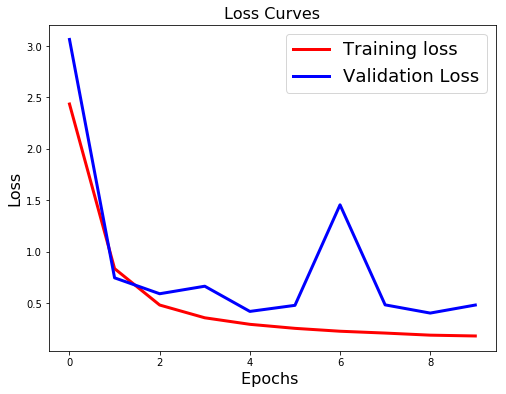

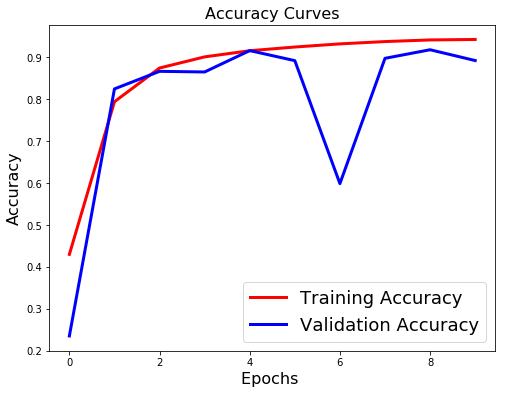

In [0]:
plot_loss_accuracy(history)

Load the Model with the Best Validation Loss

In [0]:
model.load_weights('drive/My Drive/Vietnamese/weights.hdf5')

# Test the Model

In [0]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

3960/3960 [==============================] - 11s 3ms/step
Test Accuracy: 0.9181818183022316
Test Loss: 0.4026497531080186


# Training More on the best model

In [0]:
epochs = 20
batch_size = 20

checkpointer = ModelCheckpoint(filepath='drive/My Drive/Vietnamese/weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          


Train on 17688 samples, validate on 3960 samples
Epoch 1/20
17688/17688 [==============================] - 164s 9ms/step - loss: 0.1736 - acc: 0.9446 - val_loss: 0.3813 - val_acc: 0.9270

Epoch 00001: val_loss improved from inf to 0.38135, saving model to drive/My Drive/Vietnamese/weights.hdf5
Epoch 2/20
17688/17688 [==============================] - 162s 9ms/step - loss: 0.1690 - acc: 0.9448 - val_loss: 0.4267 - val_acc: 0.9141

Epoch 00002: val_loss did not improve from 0.38135
Epoch 3/20
17688/17688 [==============================] - 160s 9ms/step - loss: 0.1586 - acc: 0.9480 - val_loss: 0.3841 - val_acc: 0.9258

Epoch 00003: val_loss did not improve from 0.38135
Epoch 4/20
17688/17688 [==============================] - 162s 9ms/step - loss: 0.1493 - acc: 0.9521 - val_loss: 0.3965 - val_acc: 0.9154

Epoch 00004: val_loss did not improve from 0.38135
Epoch 5/20
17688/17688 [==============================] - 161s 9ms/step - loss: 0.1378 - acc: 0.9546 - val_loss: 0.3670 - val_acc: 0.93

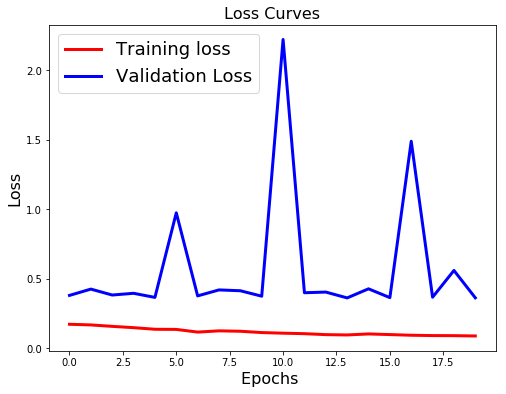

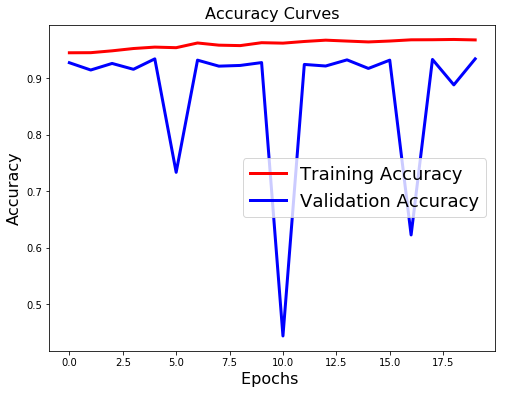

In [0]:
model.load_weights('drive/My Drive/Vietnamese/weights.hdf5')
plot_loss_accuracy(history)

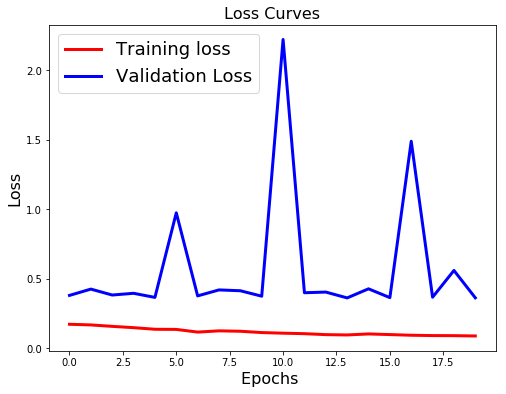

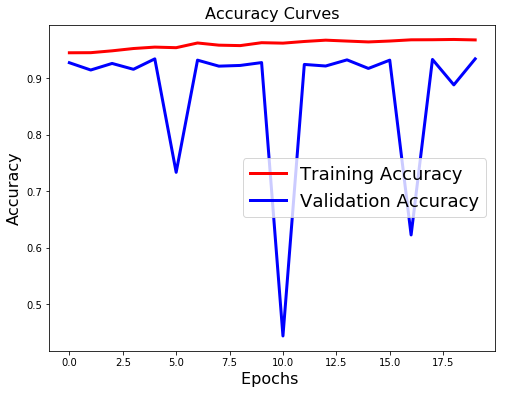

In [0]:
plot_loss_accuracy(history)

# Testing the Model again

In [0]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

3960/3960 [==============================] - 12s 3ms/step
Test Accuracy: 0.9320707071911205
Test Loss: 0.3633366194958187


After training the model on more epochs we gained a better model which can classify complex patterns . So when we tested it on our test dataset we had better results than before.

Test accuracy is improved from 93.459% to 93.459% As we train the model on 20 more epochs.

# Saving the Final Model
Let's save the model on json format to be used later instead of creating the model again from scratch.

In [0]:
from keras.models import model_from_yaml
model_yaml = model.to_yaml()
with open("drive/My Drive/Vietnamese/model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

Save the model weights to file.

In [0]:

# serialize weights to HDF5
model.save_weights("drive/My Drive/Vietnamese/model.h5")
print("Saved model to disk")

Saved model to disk


# Predicting Validation Data


In [0]:
pip install -U PyYAML

  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Predicting the Labels for Validation Data

In [21]:
from keras.models import load_model
from keras.models import model_from_yaml
import yaml
from yaml import load
import sys

yaml_file = open('/content/drive/My Drive/Vietnamese/model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Vietnamese/model.h5")
print("Loaded model from disk")


Loaded model from disk


In [0]:
# Predict the values from the validation dataset
Y_pred = loaded_model.predict(testing_data_images)

# Creating a Confusion Matrix Using Predicted and Actual Labels

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

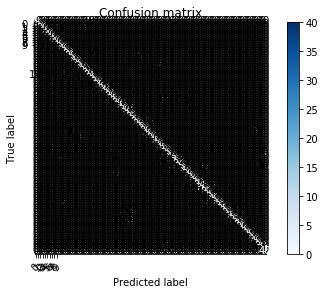

In [0]:
import itertools
from sklearn.metrics import confusion_matrix
Y_val=testing_data_labels
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix


plot_confusion_matrix(confusion_mtx, classes = range(10))

# Predicting Test Data
This time, we’ll predict classes for unseen images. These images are not used in training or validation.

In [0]:
# predict results
results = loaded_model.predict(testing_data_images)
# select the index with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

# Save Predictions
The predicted labels are stored in a CSV file using the pandas to_csv function

In [0]:
submit = pd.concat([pd.Series(range(1,3961),name = "ImageId"),results],axis = 1)
submit.to_csv("drive/My Drive/Vietnamese/cnn_vietname_predictions.csv",index=False)

# Test Predictions

In [0]:
Test = pd.read_csv('drive/My Drive/Vietnamese/cnn_vietname_predictions.csv', header = None)

In [0]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3961 entries, 0 to 3960
Data columns (total 2 columns):
0    3961 non-null object
1    3961 non-null object
dtypes: object(2)
memory usage: 62.0+ KB


In [0]:
Test.head()

,0,1
0,ImageId,Label
1,1,10
2,2,11
3,3,22
4,4,22


In [0]:
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)
def display_image(x, img_size, number_of_images):
    plt.figure(figsize = (8, 7))
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

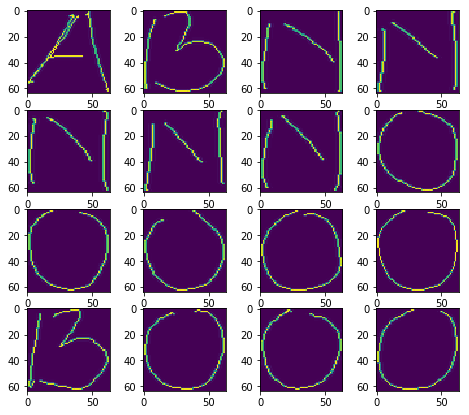

In [24]:
display_image(testing_letters_images, 64, 16)